# 설명
### 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


### train_err_data.csv : 시스템에 발생한 에러 로그

### train_quality_data.csv : 시스템 퀄리티 로그

### train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간



### 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


### test_err_data.csv : 시스템에 발생한 에러 로그

### test_quality_data.csv : 시스템 퀄리티 로그

### sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = './data/'

In [2]:
# train data load
train_err = pd.read_csv('./data/train_err_data.csv')
train_quality = pd.read_csv('./data/train_quality_data.csv')
train_problem = pd.read_csv('./data/train_problem_data.csv')

# test data load
test_err = pd.read_csv('./data/test_err_data.csv')
test_quality = pd.read_csv('./data/test_quality_data.csv')

In [3]:
print(f'train_err의 shape : {train_err.shape}')
print(f'train_quality의 shape : {train_quality.shape}')
print(f'train_problem의 shape : {train_problem.shape}')

train_err의 shape : (16554663, 6)
train_quality의 shape : (828624, 16)
train_problem의 shape : (5429, 2)


In [4]:
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [5]:
display(train_quality.head())

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


In [6]:
display(train_problem.head())
np.sort(train_problem['user_id'].unique().tolist())

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


array([10001, 10004, 10005, ..., 24990, 24997, 24998])

In [7]:
display(train_err.head())
print(train_err.shape)
print(train_err.isnull().sum())
train_err = train_err.dropna()
print(train_err.shape)
print(train_err.info())    
display(train_err.head())



,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


(16554663, 6)
user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64
(16554662, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16554662 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 884.1+ MB
None


,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [8]:
print(np.sort(train_err.model_nm.unique()))
print(np.sort(train_err.fwver.unique()))
print(np.sort(train_err.errtype.unique()))
print(np.sort(train_err.errcode.unique()))

['model_0' 'model_1' 'model_2' 'model_3' 'model_4' 'model_5' 'model_6'
 'model_7' 'model_8']
['03.11.1141' '03.11.1149' '03.11.1167' '04.16.2641' '04.16.3345'
 '04.16.3439' '04.16.3553' '04.16.3569' '04.16.3571' '04.22.1442'
 '04.22.1656' '04.22.1666' '04.22.1684' '04.22.1750' '04.22.1778'
 '04.33.1095' '04.33.1125' '04.33.1149' '04.33.1171' '04.33.1185'
 '04.33.1261' '04.73.2237' '04.73.2571' '04.82.1684' '04.82.1730'
 '04.82.1778' '05.15.2090' '05.15.2092' '05.15.2114' '05.15.2120'
 '05.15.2122' '05.15.2138' '05.15.3104' '05.66.3237' '05.66.3571' '10'
 '8.5.3']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]
['-269' '-270' '0' ... 'scanning timeout' 'standby'
 'terminate by peer user']


In [9]:
# 피처간의 상관계수 행렬을 구합니다
cols = ['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode']
corr = train_err[cols].corr(method = 'pearson')
print(corr)

          user_id      time   errtype
user_id  1.000000  0.004576  0.020254
time     0.004576  1.000000 -0.017023
errtype  0.020254 -0.017023  1.000000


In [10]:
display(train_err.groupby('fwver')['errtype', 'errcode'].count().sort_values(by='errcode', ascending=False))

,errtype,errcode
fwver,,
04.16.3553,5237816,5237816
04.22.1750,2874213,2874213
04.33.1261,2504870,2504870
05.15.2138,1906479,1906479
03.11.1167,1505659,1505659
04.22.1778,1293946,1293946
04.33.1185,963736,963736
04.16.3571,145156,145156
04.73.2237,33537,33537


In [11]:
display(train_quality.head())
print(train_quality.shape)
print(train_quality.info())
print()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


(828624, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB
None



In [12]:
display(train_problem.head())
print(train_problem.shape)
print(train_problem.info())

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


(5429, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  5429 non-null   int64
 1   time     5429 non-null   int64
dtypes: int64(2)
memory usage: 85.0 KB
None


## 1. train_problem_data 의 유저 아이디와 불만 접수시간을 train_err_dada의 user_id와 에러타입을 엮어서 해보자

In [13]:
# train data load
train_err = pd.read_csv('./data/train_err_data.csv')
train_quality = pd.read_csv('./data/train_quality_data.csv')
train_problem = pd.read_csv('./data/train_problem_data.csv')

# test data load
test_err = pd.read_csv('./data/test_err_data.csv')
test_quality = pd.read_csv('./data/test_quality_data.csv')

print(f'train_err의 shape : {train_err.shape}')
print(f'train_quality의 shape : {train_quality.shape}')
print(f'train_problem의 shape : {train_problem.shape}')

train_err의 shape : (16554663, 6)
train_quality의 shape : (828624, 16)
train_problem의 shape : (5429, 2)


In [14]:
train_err['model_nm'].value_counts().index.tolist()

['model_1',
 'model_0',
 'model_2',
 'model_3',
 'model_4',
 'model_8',
 'model_7',
 'model_5',
 'model_6']

In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = './data/'

In [16]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [17]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [18]:
print(np.sort(train_err.errtype.unique()))
# errtype이 1부터 42까지 29를 제외한 41개가 존재.
print(np.sort(train_err.model_nm.unique()))
print(train_err.info())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]
['model_0' 'model_1' 'model_2' 'model_3' 'model_4' 'model_5' 'model_6'
 'model_7' 'model_8']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB
None


<AxesSubplot:>

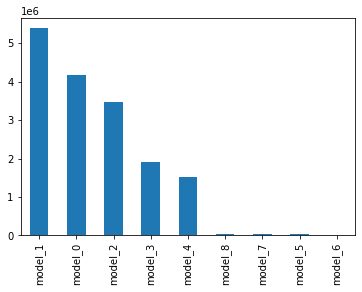

In [19]:
train_err['model_nm'].value_counts().plot.bar()

<AxesSubplot:>

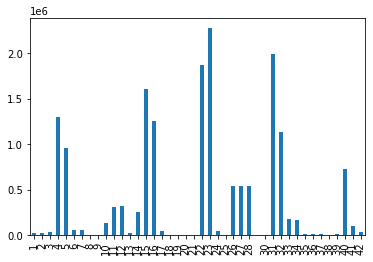

In [20]:
train_err['errtype'].value_counts().plot.bar()

In [21]:
train_err['model_nm'].value_counts()


model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [22]:
train_err['errtype'].value_counts()
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [23]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
id_error = train_err[['user_id','errtype', 'model_nm']].values
error = np.zeros((train_user_number,42))

for person_idx, err, mod in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1, mod] += 1
error.shape

  0%|                                                                                     | 0/16554663 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices